In [1]:
import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob,os,sys
from tqdm import tqdm
import datetime
import proplot as plot
from netCDF4 import Dataset
from wrf import getvar
import celer
from scipy.ndimage import gaussian_filter
import gc
import marshal
import json
import _pickle as cPickle
%matplotlib inline

sys.path.insert(1, '/work/08350/tg876493/stampede2/python_codes/2020_TC_CRF/dev/freddy0218/tools/')
import derive_var
import read_and_proc
import mlr

plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

In [2]:
#Function####################################################
import json,pickle
def nearest_index(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx.values
def save_to_pickle(loc=None,var=None):
    with open(loc,"wb") as f:
        pickle.dump(var,f)
    return None

def forward_diff(arrayin=None,delta=None,axis=None,LT=1):
    result = []
    if axis==0:
        for i in range(0,arrayin.shape[axis]-LT):
            temp = (arrayin[i+LT,:]-arrayin[i,:])/(LT*delta)
            result.append(temp)
        return np.asarray(result)
        
def do_PCA(var=None,timezoom=None,smooth='Yes',gaussian=0.9,fromcenter='Yes',inradius=None,outradius=None,donormal='Yes',do_PCA='Yes',do_center='No'):
    """
    Var: Input variable (must have 4 dimensions! Time-pres-theta-radius)
    """
    if smooth=='Yes':
        from scipy.ndimage import gaussian_filter
        normal_var = []
        if donormal=='Yes':
            for presindex in range(len(var[0,:,0,0])):
                normal_var.append(gaussian_filter(normalize_inner(var[:,presindex,:,:],outradius,'Yes'),sigma=gaussian))
        elif donormal=='No':
            if do_center=='Yes':
                for presindex in range(len(var[0,:,0,0])):
                    normal_var.append(gaussian_filter(normalize_inner(var[:,presindex,:,:],outradius,'No','Yes'),sigma=gaussian))
            elif do_center=='No':
                for presindex in range(len(var[0,:,0,0])):
                    normal_var.append(gaussian_filter(normalize_inner(var[:,presindex,:,:],outradius,'No','No'),sigma=gaussian))  
        normal_var = np.swapaxes(np.asarray(normal_var),0,1)
    else:
        normal_var = []
        for presindex in range(len(var[0,:,0,0])):
            normal_var.append(normalize_inner(var[:,presindex,:,:],outradius))
        normal_var = np.swapaxes(np.asarray(normal_var),0,1)
    if fromcenter=='Yes':
        normal_varf = np.asarray([normal_var[i,:,:,:outradius].flatten() \
                                  for i in range(len(normal_var[timezoom[0]:timezoom[1],0,0,0]))])
    elif fromcenter=='No':
        normal_varf = np.asarray([normal_var[i,:,:,inradius:outradius].flatten() \
                                  for i in range(len(normal_var[timezoom[0]:timezoom[1],0,0,0]))])        
    print("--Finish preprocesing--")
    if do_PCA=='Yes':
        from sklearn.decomposition import PCA
        import time
        start_time = time.time()
        skpcaVAR = PCA()
        skpcaVAR.fit(normal_varf.copy())
        print("--- %s seconds ---" % (time.time() - start_time))
        return skpcaVAR,normal_var,normal_varf
    else:
        return normal_var,normal_varf

def normalize_inner(var=None,outerradius=None,standard='Yes',docenter='No'):
    PWper_ctrl = []
    for indx in range(len(var[:,0,0])):
        if docenter=='Yes':
            temp = var[indx,:,:outerradius]-np.nanmean(var[indx,:,:outerradius],axis=(0,1))
        elif docenter=='No':
            temp = var[indx,:,:outerradius]
        if standard=='Yes':
            PWper_ctrl.append((temp-np.nanmean(temp))/np.nanstd(temp))
        elif standard=='No':
            PWper_ctrl.append((temp))
    del temp
    return np.asarray(PWper_ctrl)

def proc_invar_forPCA(var=None,timezoom=None,smooth='Yes',gaussian=[0,0,0],fromcenter='Yes',inradius=None,outradius=None,donormal='No',doPCA='No'):
    return do_PCA(var=var,timezoom=timezoom,smooth='Yes',gaussian=[0,0,0],fromcenter='Yes',inradius=None,outradius=None,donormal='No',doPCA='No')

def flatten(t):
    #https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-a-list-of-lists
    return [item for sublist in t for item in sublist]
def standardize(t,formula='I'):
    if formula=='I':
        return (t-np.min(np.asarray(t)))/(np.max(np.asarray(t))-np.min(np.asarray(t)))
    elif formula=='II':
        return (t-np.mean(np.asarray(t)))/(np.std(np.asarray(t)))

In [3]:
def prepare_inputdataset(inputTS=None,flat_out=np.zeros((83,12+3+3+9)),lefttimelim=None):
    def flattenlist(inlist=None):
        tempvarlist = []
        for item in inlist:
            tempvarlist.append(item)
        return flatten(tempvarlist)
    input_dataset36 = []
    for timeseries in inputTS:#[pca_timeseries_36,pcaur_timeseries_36,pcavr_timeseries_36,pcaw_timeseries_36]:
        input_dataset36.append(timeseries)
    for i in (range(inputTS[0][:,0].shape[0])):
        tempinlist = [obj[i,:] for obj in input_dataset36]
        flat_out[i,:] = flattenlist(tempinlist)
    del timeseries,i
    return flat_out

def produce_testdataset(TYPE='orig',LT=1,expTYPE='R21'):
    if expTYPE=='R21':
        if TYPE=='TCr':
            output1_TCr = np.concatenate((prepare_inputdataset([forward_diff(pcaur_timeseries,60*60,0,LT),forward_diff(pcavr_timeseries,60*60,0,LT),forward_diff(pcaw_timeseries,60*60,0,LT)],np.zeros((96,4+3+9)),ctrl_t2),
                                          prepare_inputdataset([forward_diff(pcaur_timeseries_36[36-ctrl_t2-5:],60*60,0,LT),forward_diff(pcavr_timeseries_36[36-ctrl_t2-5:],60*60,0,LT),forward_diff(pcaw_timeseries_36[36-ctrl_t2:],60*60,0,LT)],np.zeros((83,4+3+9)),ctrl_t2),
                                          prepare_inputdataset([forward_diff(pcaur_timeseries_60[60-ctrl_t2-5:],60*60,0,LT),forward_diff(pcavr_timeseries_60[60-ctrl_t2-5:],60*60,0,LT),forward_diff(pcaw_timeseries_60[60-ctrl_t2:],60*60,0,LT)],np.zeros((59,4+3+9)),ctrl_t2),
                                          prepare_inputdataset([forward_diff(pcaur_timeseries_lwcrf[36-ctrl_t2-5:],60*60,0,LT),forward_diff(pcavr_timeseries_lwcrf[36-ctrl_t2-5:],60*60,0,LT),forward_diff(pcaw_timeseries_lwcrf[36-ctrl_t2:],60*60,0,LT)],np.zeros((83,4+3+9)),ctrl_t2)),axis=0)
            return output1_TCr
        elif TYPE=='orig':
            output1_orig = np.concatenate((prepare_inputdataset([forward_diff(pcau_timeseries,60*60,0,LT),forward_diff(pcav_timeseries,60*60,0,LT),forward_diff(pcaw_timeseries,60*60,0,LT)],np.zeros((96,3+3+9)),ctrl_t2),
                                           prepare_inputdataset([forward_diff(pcau_timeseries_36[36-ctrl_t2:],60*60,0,LT),forward_diff(pcav_timeseries_36[36-28:],60*60,0,LT),forward_diff(pcaw_timeseries_36[36-ctrl_t2:],60*60,0,LT)],np.zeros((83,3+3+9)),ctrl_t2),
                                           prepare_inputdataset([forward_diff(pcau_timeseries_60[60-ctrl_t2:],60*60,0,LT),forward_diff(pcav_timeseries_60[60-28:],60*60,0,LT),forward_diff(pcaw_timeseries_60[60-ctrl_t2:],60*60,0,LT)],np.zeros((59,3+3+9)),ctrl_t2),
                                           prepare_inputdataset([forward_diff(pcau_timeseries_lwcrf[36-ctrl_t2:],60*60,0,LT),forward_diff(pcav_timeseries_lwcrf[36-28:],60*60,0,LT),forward_diff(pcaw_timeseries_lwcrf[36-ctrl_t2:],60*60,0,LT)],np.zeros((83,3+3+9)),ctrl_t2)),axis=0)
            return output1_orig

def output_flatvar_PCAtransform(var=None,ctrlvar=None,needpatch=True,exp=None,timezoom=None,smooth=[3,0,0],inradius=None,outradius=None):
    if needpatch is True:
        patchvar = read_and_proc.add_ctrl_before_senstart(ctrlvar,var,exp,'Yes')
        del var
        _,outflatvarf = do_PCA(var=patchvar,timezoom=timezoom,smooth='Yes',
                               gaussian=smooth,fromcenter='Yes',inradius=inradius,outradius=outradius,donormal='No',do_PCA='No',do_center='No')
        return outflatvarf
    else:
        _,outflatvarf = do_PCA(var=var,timezoom=timezoom,smooth='Yes',
                               gaussian=smooth,fromcenter='Yes',inradius=inradius,outradius=outradius,donormal='No',do_PCA='No',do_center='No')
        return outflatvarf

def output_PCAtimeseries(PCAdict=None,varname=None,flatvar=None,no_comp=None,standard=True,standardtype='II'):
    if varname is None:
        varname=['dtheta','u','v','w','qv']
    timeseries_out = {}
    for index,var in enumerate(varname):
        if standard is True:
            timeseries_out[var] = standardize(PCA_dict[var].transform(flatvar[index])[:,0:no_comp[index]],standardtype)
        else:
            timeseries_out[var] = PCA_dict[var].transform(flatvar[index])[:,0:no_comp[index]]
    return timeseries_out

def produce_input(PCAtimeseries=None,expname='ncrf36',orig=True,leftstart=None,no_comp=None):
    if no_comp is None:
        no_comp=[12,3,3,9,5]
    if expname=='ctrl':
        if orig is True:
            totltime=96
            dtuvw = prepare_inputdataset([PCAtimeseries['u'],PCAtimeseries['v'],PCAtimeseries['w'],PCAtimeseries['dtheta']],
                                         np.zeros((totltime,no_comp[1]+no_comp[2]+no_comp[3]+no_comp[0])),leftstart)
            uv = prepare_inputdataset([PCAtimeseries['u'],PCAtimeseries['v']],np.zeros((totltime,no_comp[1]+no_comp[2])),leftstart)
            dtuv = prepare_inputdataset([PCAtimeseries['u'],PCAtimeseries['v'],PCAtimeseries['dtheta']],np.zeros((totltime,no_comp[1]+no_comp[2]+no_comp[0])),leftstart)
            uvw = prepare_inputdataset([PCAtimeseries['u'],PCAtimeseries['v'],PCAtimeseries['w']],np.zeros((totltime,no_comp[1]+no_comp[2]+no_comp[3])),leftstart)
            uvwqv = prepare_inputdataset([PCAtimeseries['u'],PCAtimeseries['v'],PCAtimeseries['w'],PCAtimeseries['qv']],
                                     np.zeros((totltime,no_comp[1]+no_comp[2]+no_comp[3]+no_comp[4])),leftstart)
            uvqv = prepare_inputdataset([PCAtimeseries['u'],PCAtimeseries['v'],PCAtimeseries['qv']],np.zeros((totltime,no_comp[1]+no_comp[2]+no_comp[4])),leftstart)
            dtuvwqv = prepare_inputdataset([PCAtimeseries['u'],PCAtimeseries['v'],PCAtimeseries['w'],PCAtimeseries['dtheta'],PCAtimeseries['qv']],
                                           np.zeros((totltime,no_comp[1]+no_comp[2]+no_comp[3]+no_comp[0]+no_comp[4])),leftstart)
            output_dict={'uv':uv,'uvw':uvw,'uvqv':uvqv,'uvwqv':uvwqv,'dtuvw':dtuvw,'dtuvwqv':dtuvwqv,'dtuv':dtuv}
            return output_dict
    else:
        if expname=='ncrf36':
            rsindx,totltime = 36,96-(36-23)
        elif expname=='ncrf60':
            rsindx,totltime = 60,96-(60-23)
        
        if orig is True:
            dtuvw = prepare_inputdataset([PCAtimeseries['u'][rsindx-leftstart:],PCAtimeseries['v'][rsindx-leftstart:],
                                          PCAtimeseries['w'][rsindx-leftstart:],PCAtimeseries['dtheta'][rsindx-leftstart:]],np.zeros((totltime,no_comp[1]+no_comp[2]+no_comp[3]+no_comp[0])),leftstart)
            uv = prepare_inputdataset([PCAtimeseries['u'][rsindx-leftstart:],PCAtimeseries['v'][rsindx-leftstart:]],np.zeros((totltime,no_comp[1]+no_comp[2])),leftstart)
            uvw = prepare_inputdataset([PCAtimeseries['u'][rsindx-leftstart:],PCAtimeseries['v'][rsindx-leftstart:],PCAtimeseries['w'][rsindx-leftstart:]],np.zeros((totltime,no_comp[1]+no_comp[2]+no_comp[3])),leftstart)
            dtuv = prepare_inputdataset([PCAtimeseries['u'][rsindx-leftstart:],PCAtimeseries['v'][rsindx-leftstart:],PCAtimeseries['dtheta'][rsindx-leftstart:]],np.zeros((totltime,no_comp[1]+no_comp[2]+no_comp[0])),leftstart)
            uvwqv = prepare_inputdataset([PCAtimeseries['u'][rsindx-leftstart:],PCAtimeseries['v'][rsindx-leftstart:],
                                          PCAtimeseries['w'][rsindx-leftstart:],PCAtimeseries['qv'][rsindx-leftstart:]],np.zeros((totltime,no_comp[1]+no_comp[2]+no_comp[3]+no_comp[4])),leftstart)
            uvqv = prepare_inputdataset([PCAtimeseries['u'][rsindx-leftstart:],PCAtimeseries['v'][rsindx-leftstart:],PCAtimeseries['qv'][rsindx-leftstart:]],np.zeros((totltime,no_comp[1]+no_comp[2]+no_comp[4])),leftstart)
            dtuvwqv = prepare_inputdataset([PCAtimeseries['u'][rsindx-leftstart:],PCAtimeseries['v'][rsindx-leftstart:],
                                            PCAtimeseries['w'][rsindx-leftstart:],PCAtimeseries['dtheta'][rsindx-leftstart:],
                                            PCAtimeseries['qv'][rsindx-leftstart:]],np.zeros((totltime,no_comp[1]+no_comp[2]+no_comp[3]+no_comp[0]+no_comp[4])),leftstart)
            output_dict={'uv':uv,'uvw':uvw,'uvqv':uvqv,'uvwqv':uvwqv,'dtuvw':dtuvw,'dtuvwqv':dtuvwqv,'dtuv':dtuv}
            return output_dict

def produce_output_LT(PCAtimeseries=None,expname=['ctrl','ncrf36','ncrf60','lwcrf'],orig=True,leadtime=None):
    def output_timediff(LT=None,inputdict=None,settings=None,exp=None):
        if exp=='ctrl':
            a = prepare_inputdataset2([forward_diff(inputdict['u'],60*60,0,LT),forward_diff(inputdict['v'],60*60,0,LT),forward_diff(inputdict['w'],60*60,0,LT)],np.zeros((forward_diff(inputdict['u'],60*60,0,LT).shape[0],3+3+10)),ctrl_t2)
            azero = np.zeros((LT,3+3+10))
            return np.concatenate((a,azero),axis=0)
        elif (exp=='ncrf36') or (exp=='lwcrf'):
            a = prepare_inputdataset2([forward_diff(inputdict['u'][36-ctrl_t2:],60*60,0,LT),forward_diff(inputdict['v'][36-ctrl_t2:],60*60,0,LT),forward_diff(inputdict['w'][36-ctrl_t2:],60*60,0,LT)],
                                        np.zeros((forward_diff(inputdict['u'][36-ctrl_t2:],60*60,0,LT).shape[0],3+3+10)),ctrl_t2)
            azero = np.zeros((LT,3+3+10))
            return np.concatenate((a,azero),axis=0)
        elif exp=='ncrf60':
            a = prepare_inputdataset2([forward_diff(inputdict['u'][60-ctrl_t2:],60*60,0,LT),forward_diff(inputdict['v'][60-ctrl_t2:],60*60,0,LT),forward_diff(inputdict['w'][60-ctrl_t2:],60*60,0,LT)],
                                        np.zeros((forward_diff(inputdict['u'][60-ctrl_t2:],60*60,0,LT).shape[0],3+3+10)),ctrl_t2)
            azero = np.zeros((LT,3+3+10))
            return np.concatenate((a,azero),axis=0)

    if orig is True:
        result = []
        for index,expNAME in enumerate(expname):
            result.append(output_timediff(LT=leadtime,inputdict=PCAtimeseries[index],settings=None,exp=expNAME))
        del index,expNAME
        result_con = np.concatenate((result),axis=0)
        return result_con
    
def prepare_inputdataset2(inputTS=None,flat_out=np.zeros((83,12+3+3+9)),lefttimelim=None):
    def flattenlist(inlist=None):
        tempvarlist = []
        for item in inlist:
            tempvarlist.append(item)
        return flatten(tempvarlist)
    input_dataset36 = []
    for timeseries in inputTS:#[pca_timeseries_36,pcaur_timeseries_36,pcavr_timeseries_36,pcaw_timeseries_36]:
        input_dataset36.append(timeseries)
    for i in (range(inputTS[0][:,0].shape[0])):
        tempinlist = [obj[i,:] for obj in input_dataset36]
        flat_out[i,:] = flattenlist(tempinlist)
    del timeseries,i
    return flat_out
        
#    produce_testdataset(TYPE='TCr',LT=1,expTYPE='R21'),produce_testdataset(TYPE='TCr',LT=2,expTYPE='R21'),produce_testdataset(TYPE='TCr',LT=3,expTYPE='R21')

In [4]:
from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import MultiTaskLassoCV
from celer import MultiTaskLassoCV
from celer import Lasso
from sklearn.linear_model import ElasticNet
def produce_regscore(inPUT=None,outPUT=None,aux_inPUT=None,outtype='score',do_aux=False,
                     algorithm='linear',lassoparam=dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),simplelassoalpha=0.001):
    if algorithm=='linear':
        reg = LinearRegression().fit(inPUT, outPUT)
    elif algorithm=='lasso':
        #reg = MultiTaskLassoCV(**lassoparam).fit(inPUT,outPUT)
        reg = Lasso(simplelassoalpha).fit(inPUT,outPUT)
    elif algorithm=='multilasso':
        reg = MultiTaskLassoCV(**lassoparam).fit(inPUT,outPUT)
    if outtype=='score':
        if do_aux is False:
            return reg.score(inPUT, outPUT)
        elif do_aux is True:
            return reg.score(aux_inPUT,outPUT)
    elif outtype=='predict':
        if do_aux is False:
            return reg.predict(inPUT)
        elif do_aux is True:
            return reg.predict(aux_inPUT)
    elif outtype=='coeff':
        return reg.coef_
    
def delete_padding(inTS=None,outTS=None):
    output_nozero,input_nozero = [],[]
    for i in range(len(outTS[:,0])):
        temp = outTS[i,:]
        tempin = inTS[i,:]
        if temp.all()==0:
            continue
        else:
            output_nozero.append(temp)
            input_nozero.append(tempin)
    return input_nozero,output_nozero

def output_regscore(inTS=None,outTS=None,LTlist=None,algorithm='linear',aux_inTS=None,do_aux=False,simplelassoalpha=0.001):
    if do_aux is False:
        return [produce_regscore(delete_padding(inTS,outTS[i])[0],delete_padding(inTS,outTS[i])[1],None,'score',False,algorithm,\
                                 dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),simplelassoalpha) for i in range(len(outTS))]
    elif do_aux is True:
        return [produce_regscore(delete_padding(inTS,outTS[i])[0],delete_padding(inTS,outTS[i])[1],aux_inTS[:-int(LTlist[i])],'score',True,algorithm,\
                                 dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),simplelassoalpha) for i in range(len(outTS))]
    
def output_regscore_withmemory(inTS=None,outTS=None,LTlist=None,algorithm='linear',aux_inTS=None,do_aux=False,simplelassoalpha=0.001):
    if do_aux is False:
        output = []
        for i in (range(len(outTS))):
            inTSn,outTSn = delete_padding(inTS,outTS[i])[0],delete_padding(inTS,outTS[i])[1]
            inTRAIN = np.concatenate(((inTSn[int(LTlist[i]):]),(inTSn[0:-int(LTlist[i])])),axis=1)
            outTRAIN = outTSn[int(LTlist[i]):]
            output.append(produce_regscore(inTRAIN,outTRAIN,None,'score',False,algorithm,dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),simplelassoalpha))
        return output
    elif do_aux is True:
        output = []
        for i in (range(len(outTS))):
            inTSn,outTSn = delete_padding(inTS,outTS[i])[0],delete_padding(inTS,outTS[i])[1]
            inTRAIN = np.concatenate(((inTSn[int(LTlist[i]):]),(inTSn[0:-int(LTlist[i])])),axis=1)
            outTRAIN = outTSn[int(LTlist[i])]
            auxin = np.concatenate(((aux_inTS[:-int(LTlist[i])][int(LTlist[i]):]),(aux_inTS[:-int(LTlist[i])][0:-int(LTlist[i])])),axis=1)
            output.append(produce_regscore(inTRAIN,outTRAIN,auxin,'score',True,algorithm,dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),simplelassoalpha))
        return output        
    
def output_regcoeff(inTS=None,outTS=None,LTlist=None,algorithm='linear',memory='with',simplelassoalpha=0.001):
    if memory=='with':
        output = []
        for i in range(len(outTS)):
            inarray = np.concatenate(((inTS[:-int(LTlist[i])][int(LTlist[i]):]),(inTS[:-int(LTlist[i])][0:-int(LTlist[i])])),axis=1)
            outarray = outTS[i][int(LTlist[i]):-int(LTlist[i])]
            output.append(produce_regscore(inarray,outarray,'coeff',algorithm,dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),0.01))
        return output
    elif memory=='without':
        return [produce_regscore(inTS[:-int(LTlist[i])],outTS[i][:-int(LTlist[i])],'coeff',algorithm,dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),simplelassoalpha) for i in range(len(outTS))]
    
def output_regpredict(inTS=None,outTS=None,LTlist=None,algorithm='linear',memory='without',simplelassoalpha=0.001,do_aux=False,aux_inTS=None):
    if memory=='with':
        output = []
        for i in range(len(outTS)):
            inarray = np.concatenate(((inTS[:-int(LTlist[i])][int(LTlist[i]):]),(inTS[:-int(LTlist[i])][0:-int(LTlist[i])])),axis=1)
            outarray = outTS[i][int(LTlist[i]):-int(LTlist[i])]
            output.append(produce_regscore(inarray,outarray,None,'predict',False,algorithm,dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),0.01))
        return output
    elif memory=='without':
        if do_aux is False:
            return [produce_regscore(delete_padding(inTS,outTS[i])[0],delete_padding(inTS,outTS[i])[1],None,'predict',False,algorithm,dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),simplelassoalpha) for i in range(len(outTS))]
        elif do_aux is True:
            return [produce_regscore(delete_padding(inTS,outTS[i])[0],delete_padding(inTS,outTS[i])[1],delete_padding(aux_inTS,outTS[i])[0],
                                     'predict',True,algorithm,dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),simplelassoalpha) for i in range(len(outTS))]

### Reconstruct - I. Input save variables

In [5]:
############################################################################################################################################
# PCA_dict: Processed EOF objects; A_dict: Variable anomaly matrices; Af_dict: Flattened variable anomaly matrices
# *note that following EOF conventions, we derived EOFs with anomalies.
############################################################################################################################################
import pickle
path = './output/1010_nc/'
filePCA = [path+'U_pca_nc',path+'V_pca_nc',path+'W_pca_nc']
fileAf = [path+'normalUrad_ctrlf_nc',path+'normalVtan_ctrlf_nc',path+'normalW_ctrlf_nc',\
          path+'normalUradG_ctrlf_nc',path+'normalVtanG_ctrlf_nc',path+'normalWG_ctrlf_nc']

outputPCA,outputA,outputAf = [],[],[]
for i in range(len(filePCA)):
    with open(filePCA[i],'rb') as f:
        outputPCA.append(pickle.load(f))
for i in range(len(fileAf)):
    with open(fileAf[i],'rb') as f:
        outputAf.append(pickle.load(f))

PCA_dict = {'u':outputPCA[0],'v':outputPCA[1],'w':outputPCA[2]}
Af_dict = {'u':outputAf[0],'v':outputAf[1],'w':outputAf[2],'ugrad':outputAf[3],'vgrad':outputAf[4],'wgrad':outputAf[5]}

fileA = [path+'normalT_ctrl_nc']
outputA = []
for i in range(len(fileA)):
    with open(fileA[i],'rb') as f:
        outputA.append(pickle.load(f))
A_dict = {'dtheta':outputA[0]}
del outputPCA,outputAf,outputA
gc.collect()

84

#### How many PCA components do we need?

In [ ]:
TESTu = [np.dot(forward_diff(PCA_dict['u'].transform(Af_dict['u'])[:,0:int(i)],60*60,0,1),(PCA_dict['u'].components_[0:int(i)])) for i in np.linspace(0,25,26)]
TESTv = [np.dot(forward_diff(PCA_dict['v'].transform(Af_dict['v'])[:,0:int(i)],60*60,0,1),(PCA_dict['v'].components_[0:int(i)])) for i in np.linspace(0,25,26)]
TESTw = [np.dot(forward_diff(PCA_dict['w'].transform(Af_dict['w'])[:,0:int(i)],60*60,0,1),(PCA_dict['w'].components_[0:int(i)])) for i in np.linspace(0,25,26)]
TESTu_var,TESTv_var,TESTw_var = [np.var(obj)/np.var(Af_dict['ugrad']) for obj in TESTu],[np.var(obj)/np.var(Af_dict['vgrad']) for obj in TESTv],[np.var(obj)/np.var(Af_dict['wgrad']) for obj in TESTw]

In [18]:
TESTu_var,TESTv_var,TESTw_var

([0.0,
  0.055644378,
  0.21897446,
  0.3540133,
  0.4502482,
  0.48931992,
  0.54894376,
  0.61764055,
  0.6989541,
  0.7313014,
  0.7783507,
  0.82667214,
  0.86172575,
  0.8984242,
  0.9210121,
  0.94274694,
  0.95803684,
  0.96942,
  0.977917,
  0.98425573,
  0.98919123,
  0.992516,
  0.99492764,
  0.99649227,
  0.997581,
  0.99839705],
 [0.0,
  0.090995066,
  0.18112001,
  0.2895565,
  0.36697838,
  0.4615805,
  0.53105175,
  0.598361,
  0.68478376,
  0.7360717,
  0.77619374,
  0.8167559,
  0.8551183,
  0.889458,
  0.91719055,
  0.93826056,
  0.9555567,
  0.96713907,
  0.9757122,
  0.9820976,
  0.9873325,
  0.99069315,
  0.9930986,
  0.9948011,
  0.99598026,
  0.9967168],
 [0.0,
  0.037064895,
  0.089349665,
  0.13333263,
  0.17496534,
  0.24405399,
  0.29135177,
  0.35895786,
  0.4215023,
  0.49477845,
  0.569455,
  0.6269195,
  0.6803506,
  0.74581873,
  0.79514545,
  0.83623123,
  0.8740697,
  0.903196,
  0.9259313,
  0.9443117,
  0.9586138,
  0.96957827,
  0.9774786,
  0.98297

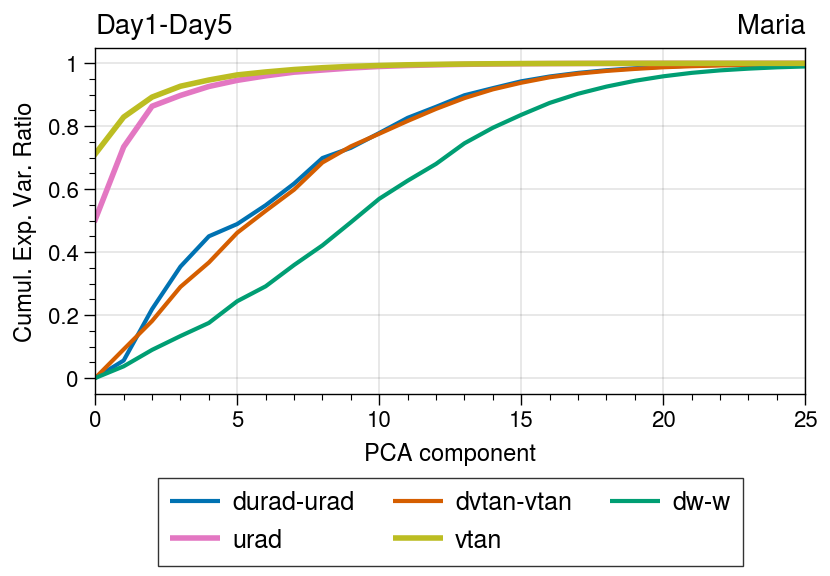

In [14]:
cmap = mpl.cm.get_cmap('tab10')
cmapC = cmap((np.linspace(0.15,0.8,5)))
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=3.55,refaspect=2.051)
axs[0].plot(np.linspace(0,25,26),TESTu_var,label='durad-urad')
axs[0].plot(np.linspace(0,25,26),TESTv_var,label='dvtan-vtan')
axs[0].plot(np.linspace(0,25,26),TESTw_var,label='dw-w')
axs[0].plot(np.linspace(0,PCA_dict['u'].explained_variance_ratio_.cumsum().shape[0]-1,PCA_dict['u'].explained_variance_ratio_.cumsum().shape[0]),PCA_dict['u'].explained_variance_ratio_.cumsum(),lw=2,label=r'urad',color=cmapC[3])
axs[0].plot(np.linspace(0,PCA_dict['v'].explained_variance_ratio_.cumsum().shape[0]-1,PCA_dict['v'].explained_variance_ratio_.cumsum().shape[0]),PCA_dict['v'].explained_variance_ratio_.cumsum(),lw=2,label=r'vtan',color=cmapC[4])
axs[0].format(xlabel='PCA component',ylabel='Cumul. Exp. Var. Ratio')
axs[0].legend(loc='b')
axs.format(xlim=[0,25],ltitle='Day1-Day5',rtitle='Maria')
for axis in axs:
    axis.yaxis.label.set_size(8.5)
    axis.xaxis.label.set_size(8.5)
    axis.tick_params(axis='both', which='major', labelsize=8)
plt.savefig('./proc_fig/1129/varratio_performance.png',dpi=400)
plt.show()

In [6]:
path = './output/1010_nc/'
file2 = [path+'normalUrad_ncrf36f_nc',path+'normalUrad_ncrf60f_nc',path+'normalUrad_lwcrff_nc',path+'normalVtan_ncrf36f_nc',path+'normalVtan_ncrf60f_nc',path+'normalVtan_lwcrff_nc']

output = []
for i in range(len(file2)):
    with open(file2[i],'rb') as f:
        output.append(pickle.load(f))
normalUradncrf36f,normalUradncrf60f,normalUradlwcrff = output[0],output[1],output[2]
normalVtanncrf36f,normalVtanncrf60f,normalVtanlwcrff = output[3],output[4],output[5]
del output
gc.collect()

16

In [7]:
path = './output/1010_nc/MLR_train/'
file2 = [path+'mlr_inputdictN_T6_norm',path+'mlr_outputN_T6_norm']

output = []
for i in range(len(file2)):
    with open(file2[i],'rb') as f:
        output.append(pickle.load(f))
mlr_inputdict,mlr_output = output[0],output[1]
del output
gc.collect()

# Radiation input
path = './output/1010_nc/MLR_train/radiation/'
file2 = [path+'mlr_inputdictNNOIR_T6']
output = []
for i in range(len(file2)):
    with open(file2[i],'rb') as f:
        output.append(pickle.load(f))
mlr_inputdict_aux = output[0]
del output
gc.collect()

0

In [8]:
origin_path = '/scratch/06040/tg853394/tc/output/redux/maria/'

#############################################################
ctrlvar_dict = read_and_proc.read_some_azimuth_fields(fileloc=[origin_path+'ctl/azim_W_0-144hr.nc'],fieldname=['W'])
ncrf60var_dict = read_and_proc.read_some_azimuth_fields(fileloc=[origin_path+'ncrf_60h/azim_W_60-144hr.nc'],fieldname=['W'])
ncrf36var_dict = read_and_proc.read_some_azimuth_fields(fileloc=[origin_path+'ncrf_36h/azim_W_36-144hr.nc'],fieldname=['W'])
lwcrfvar_dict = read_and_proc.read_some_azimuth_fields(fileloc=[origin_path+'lwcrf/azim_W_36-144hr.nc'],fieldname=['W'])
################################################################################################################################################################################################################
######################################################################################################################################
# Settings
# (a) Cut off time
#.....................................................................................................................
ctrl_t2,ctrl_t4 = nearest_index(ctrlvar_dict['W']['W'].time/24,1)-1,nearest_index(ctrlvar_dict['W']['W'].time/24,5)-1
#.....................................................................................................................
r0,r200=(nearest_index(ctrlvar_dict['W']['W'].radius,0),nearest_index(ctrlvar_dict['W']['W'].radius,200))
r300,r500=(nearest_index(ctrlvar_dict['W']['W'].radius,300),nearest_index(ctrlvar_dict['W']['W'].radius,500))
######################################################################################################################################

######################################################################################################################################
# Process variables
#.....................................................................................................................
# (I) W
#.....................................................................................................................
normalWncrf36f,normalWncrf60f,normalWlwcrff = output_flatvar_PCAtransform(ncrf36var_dict['W'].W,ctrlvar_dict['W'].W,True,'NCRF36',[ctrl_t2,ctrl_t4],[3,0,0],None,r500),\
output_flatvar_PCAtransform(ncrf60var_dict['W'].W,ctrlvar_dict['W'].W,True,'NCRF60',[ctrl_t2,ctrl_t4],[3,0,0],None,r500),output_flatvar_PCAtransform(lwcrfvar_dict['W'].W,ctrlvar_dict['W'].W,True,'NCRF36',[ctrl_t2,ctrl_t4],[3,0,0],None,r500)
del ctrlvar_dict,ncrf36var_dict,ncrf60var_dict,lwcrfvar_dict
gc.collect()

--Finish preprocesing--
--Finish preprocesing--
--Finish preprocesing--


40

In [9]:
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

import json,pickle
def save_to_pickle(loc=None,var=None,TYPE='PICKLE'):
    if TYPE=='PICKLE':
        with open(loc,"wb") as f:
            pickle.dump(var,f)
        return None
    elif TYPE=='cPICKLE':
        with open(loc,"wb") as f:
            cPickle.dump(var,f)
        return None
    elif TYPE=='JSON':
        #dumpedvar = json.dumps(var, cls=NumpyEncoder)
        with open(loc,"wb") as f:
            json.dump(var.tolist(),f)
        return None
    elif TYPE=='MARSHAL':
        with open(loc,"wb") as f:
            marshal.dump(var.tolist(),f)
        return None        

def windrates_real(u=[Af_dict['u'],normalUradncrf36f,normalUradncrf60f,normalUradlwcrff],
                   v=[Af_dict['v'],normalVtanncrf36f,normalVtanncrf60f,normalVtanlwcrff],w=[Af_dict['w'],normalWncrf36f,normalWncrf60f,normalWlwcrff],LT=None):
    # dudt
    dudtT = [forward_diff(uobj,60*60,0,LT) for uobj in u]
    #print([obj.shape[0] for obj in dudtT])
    dudt = np.concatenate((dudtT[0],dudtT[1][(36-23):],dudtT[2][(60-23):],dudtT[3][(36-23):]),axis=0)
    del dudtT
    # dvdt
    dvdtT = [forward_diff(vobj,60*60,0,LT) for vobj in v]
    dvdt = np.concatenate((dvdtT[0],dvdtT[1][(36-23):],dvdtT[2][(60-23):],dvdtT[3][(36-23):]),axis=0)
    del dvdtT 
    # dwdt
    dwdtT = [forward_diff(wobj,60*60,0,LT) for wobj in w]
    dwdt = np.concatenate((dwdtT[0],dwdtT[1][(36-23):],dwdtT[2][(60-23):],dwdtT[3][(36-23):]),axis=0)
    del dwdtT 
    return dudt,dvdt,dwdt

def recon_from_linear(forecast_eiginput=None,PCA_dict=None,LT=None,numcomp=[11,12,12],output_type='R2',savepath=None,TYPE='PICKLE',TIMESTEP='Yes',ts=48,
                     sen_exp='Yes',exp_type='CTRL'):
    def output_reshapeRECON(forecast_eig=None,PCAdict=None):
        testrec_dudt = np.dot(forecast_eig[:,0:numcomp[0]],(PCA_dict['u'].components_[0:numcomp[0]]))#.reshape((91,39,360,167))
        testrec_dvdt = np.dot(forecast_eig[:,numcomp[0]:numcomp[0]+numcomp[1]],(PCA_dict['v'].components_[0:numcomp[1]]))#.reshape((91,39,360,167))
        testrec_dwdt = np.dot(forecast_eig[:,numcomp[0]+numcomp[1]:],(PCA_dict['w'].components_[0:numcomp[2]]))#.reshape((39,360,167))
        return testrec_dudt,testrec_dvdt,testrec_dwdt
    ######################################################################################################################################################
    name = ['dudt','dvdt','dwdt']
    if output_type=='R2':
        temp1,temp2,temp3 = [],[],[]
        temp1b,temp2b,temp3b = [],[],[]
        for i in tqdm(range(len(LT))):
            teMP1,teMP2,teMP3 = output_reshapeRECON(forecast_eiginput[int(LT[i])-1],PCA_dict)
            reteMP1,reteMP2,reteMP3 = windrates_real(LT=int(LT[i]))#int(i+1))
            # Square error
            temp1.append(np.sum((teMP1-reteMP1)**2))
            del reteMP1
            gc.collect()
            temp2.append(np.sum((teMP2-reteMP2)**2))
            del reteMP2
            gc.collect()
            temp3.append(np.sum((teMP3-reteMP3)**2))
            del reteMP3
            gc.collect()
            # Variance
            temp1b.append(np.sum((teMP1-np.nanmean(teMP1))**2))
            del teMP1
            gc.collect()
            temp2b.append(np.sum((teMP2-np.nanmean(teMP2))**2))
            del teMP2
            gc.collect()
            temp3b.append(np.sum((teMP3-np.nanmean(teMP3))**2))
            del teMP3
            gc.collect()
        del i
        se_store = {name[0]:temp1,name[1]:temp2,name[2]:temp3}
        va_store = {name[0]:temp1b,name[1]:temp2b,name[2]:temp3b}
        return se_store,va_store
    elif output_type=='components':
#        temp1,temp2,temp3 = [],[],[]
        for i in tqdm(range(len(LT))):
            teMP1,teMP2,teMP3 = output_reshapeRECON(forecast_eiginput[int(LT[i])-1],PCA_dict)
            if TIMESTEP=='Yes':
                if sen_exp=='Yes':
                    if exp_type=='NCRF36':
                        save_to_pickle(loc=savepath+'/urecon_'+exp_type+'_'+str(int(ts))+'_'+str(int(LT[i])),
                                       var=teMP1[(96-int(LT[i]))+(int(ts)-36),:],TYPE=TYPE)
                        save_to_pickle(loc=savepath+'/vrecon_'+exp_type+'_'+str(int(ts))+'_'+str(int(LT[i])),
                                       var=teMP2[(96-int(LT[i]))+(int(ts)-36),:],TYPE=TYPE)
                        save_to_pickle(loc=savepath+'/wrecon_'+exp_type+'_'+str(int(ts))+'_'+str(int(LT[i])),
                                       var=teMP3[(96-int(LT[i]))+(int(ts)-36),:],TYPE=TYPE)
                else:
                    save_to_pickle(loc=savepath+'/urecon_'+str(int(ts))+'_'+str(int(LT[i])),var=teMP1[int(ts),:],TYPE=TYPE)
                    save_to_pickle(loc=savepath+'/vrecon_'+str(int(ts))+'_'+str(int(LT[i])),var=teMP2[int(ts),:],TYPE=TYPE)
                    save_to_pickle(loc=savepath+'/wrecon_'+str(int(ts))+'_'+str(int(LT[i])),var=teMP3[int(ts),:],TYPE=TYPE)
            else:
                save_to_pickle(loc=savepath+'/urecon'+str(int(LT[i])),var=teMP1,TYPE=TYPE)
                save_to_pickle(loc=savepath+'/vrecon'+str(int(LT[i])),var=teMP2,TYPE=TYPE)
                save_to_pickle(loc=savepath+'/wrecon'+str(int(LT[i])),var=teMP3,TYPE=TYPE)                
            #temp1.append(teMP1)
            #temp2.append(teMP2)
            #temp3.append(teMP3)
            del teMP1,teMP2,teMP3
            gc.collect()
        return None

### Reconstruct - Model Performance
Note: We are seeing a trade-off between accuracy, model complexity, and whether heating/vertical velocity yields improvements

Discuss: What is the optimal setting for our need?

In [15]:
gc.collect()
from copy import deepcopy
# Only dthetadt -12
mlr_input_dtuvw_onlydt = deepcopy(mlr_inputdict['dtuvw']) #np.zeros_like(mlr_inputdict['dtuvw'])

#mlr_input_dtuvw_onlydt[:,0:-12]=mlr_inputdict['dtuvw'][:,0:-12]
#mlr_input_dtuvw_onlydt[:,-12:]=mlr_inputdict['dtuvw'][:,-12:]
#mlr_input_dtuvw_onlydt[:,-12]=mlr_inputdict['dtuvw'][:,-12:][:,0]
mlr_input_dtuvw_onlydt[:,-11]=mlr_inputdict['dtuvw'][:,-12:][:,1]
#mlr_input_dtuvw_onlydt[:,-10]=mlr_inputdict['dtuvw'][:,-12:][:,2] #dthdt3
#mlr_input_dtuvw_onlydt[:,-8]=mlr_inputdict['dtuvw'][:,-12:][:,4] #dthdt5
#mlr_input_dtuvw_onlydt[:,-6]=mlr_inputdict['dtuvw'][:,-12:][:,6] #dthdt7
#mlr_input_dtuvw_onlydt[:,-7]=mlr_inputdict['dtuvw'][:,-12:][:,5] #dthdt6

In [16]:
del u9_recon_dthdt,v9_recon_dthdt,w9_recon_dthdt
del testu,testv,testw
gc.collect()

16

In [10]:
# Test 1: [12,12,15] 85% variances 
# Test 2: [3,3,10] 20% duv, 50% dw
# Test 3: [6,6,10] 50% variance
import gc
import importlib
importlib.reload(mlr)

LDTME = [3,6,9,12,15,18,24,27,30,33,36]#[1,3,6,9,12,15,18,21,24]#np.linspace(0,23,24)+1
#nocomp = [3,3,10]
#nocomp = [6,6,10]
#nocomp = [8,8,12]
#nocomp = [9,9,13]
nocomp = [11,11,15]
#nocomp = [14,14,18]

#################################################################################################################
# (a) Output Error and Variability for R^2 calculation (original input)
#forecast_eiginput = output_regpredict(mlr_inputdict['dtuvw'],mlr_output,LDTME,'linear','without',0.001)
#uv_recondict1,uv_recondict2 = recon_from_linear(forecast_eiginput,PCA_dict,LDTME,nocomp)
#dtuvw_recondict1,dtuvw_recondict2 = mlr.recon_from_linear(forecast_eiginput,PCA_dict,LDTME,nocomp,True,\
#                                                         [Af_dict['u'],normalUradncrf36f,normalUradncrf60f,normalUradlwcrff],
#                                                          [Af_dict['v'],normalVtanncrf36f,normalVtanncrf60f,normalVtanlwcrff],
#                                                         [Af_dict['w'],normalWncrf36f,normalWncrf60f,normalWlwcrff],
#                                                         '/scratch/08350/tg876493/mlr_output/exp6/dtuvw/')
#################################################################################################################
# (b) Only input = heating terms
forecast_eiginput = output_regpredict(mlr_inputdict['dtuvw'],mlr_output,LDTME,'linear','without',0.001,True,mlr_inputdict_aux['dtuvw'])#mlr_input_dtuvw_onlydt)
#u9_recon_dthdt,v9_recon_dthdt,w9_recon_dthdt = recon_from_linear(forecast_eiginput,PCA_dict,LDTME,nocomp,'components',\
#                                                                '/scratch/08350/tg876493/mlr_output/exp6/dtuvw/reconstruct/all/')
recon_from_linear(forecast_eiginput,PCA_dict,LDTME,nocomp,'components','/scratch/08350/tg876493/mlr_output/exp6/dtuvw/reconstruct/all/noir/ncrf36_48',\
                 'PICKLE','Yes',48,'Yes','NCRF36') #cPICKLE
del forecast_eiginput
gc.collect()

#forecast_eiginput = output_regpredict(mlr_inputdict['dtuvw'],mlr_output,LDTME,'linear','without',0.001)
#u9_recon_all,v9_recon_all,w9_recon_all = recon_from_linear(forecast_eiginput,PCA_dict,LDTME,nocomp,output_type='components')
#del forecast_eiginput
#gc.collect()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [02:28<00:00, 13.53s/it]


0

##### Read in processed files

In [ ]:
def read_in_processed(pathSE=None,pathVA=None):
    outputUVse,outputUVva = [],[]
    for i in range(len(pathSE)):
        with open(pathSE[i],'rb') as f:
            outputUVse.append(pickle.load(f))
    for i in range(len(pathVA)):
        with open(pathVA[i],'rb') as f:
            outputUVva.append(pickle.load(f))
    #SE_dict = {'exp1':outputUVse[0],'exp2':outputUVse[1],'exp3':outputUVse[2],'exp4':outputUVse[3],'exp5':outputUVse[4],'exp6':outputUVse[5]}
    #VA_dict = {'exp1':outputUVva[0],'exp2':outputUVva[1],'exp3':outputUVva[2],'exp4':outputUVva[3],'exp5':outputUVva[4],'exp6':outputUVva[5]}
    SE_dict = {'exp1':outputUVse[0],'exp5':outputUVse[1],'exp6':outputUVse[2]}
    VA_dict = {'exp1':outputUVva[0],'exp5':outputUVva[1],'exp6':outputUVva[2]}
    return SE_dict,VA_dict

def read_in_processed_oneexp(inpath=None,exp='T1',var=None):
    SEpath_in = [sorted(glob.glob(inpath+str(obj)+'_s*_'+str(exp)))[0] for obj in var]
    VApath_in = [sorted(glob.glob(inpath+str(obj)+'_v*_'+str(exp)))[0] for obj in var]
    outputUVse,outputUVva = [],[]
    for i in range(len(SEpath_in)):
        with open(SEpath_in[i],'rb') as f:
            outputUVse.append(pickle.load(f))
    for i in range(len(VApath_in)):
        with open(VApath_in[i],'rb') as f:
            outputUVva.append(pickle.load(f))
            
    SE_dict,VA_dict={},{}
    for index,varobj in enumerate(var):
        SE_dict[varobj] = outputUVse[int(index)]
        VA_dict[varobj] = outputUVva[int(index)]
    #{'uv':outputUVva[0],'uvqv':outputUVva[1],'uvwqv':outputUVva[2],'dtuvw':outputUVva[3],'dtuvwqv':outputUVva[4]}
    return SE_dict,VA_dict

##### One experiment

In [7]:
#SE_T1,VA_T1 = read_in_processed_oneexp('./output/1010_nc/R2/','T1',['uv','uvqv','uvwqv','dtuvw','dtuvwqv'])
#exp = ['uv','uvqv','uvwqv','dtuvw','dtuvwqv']
#R2_T1 = []
#for index,obj in enumerate(exp):
#    R2_T1.append(1-(np.asarray(SE_T1[obj]['dudt'])+np.asarray(SE_T1[obj]['dvdt'])+\
#                    np.asarray(SE_T1[obj]['dwdt']))/(np.asarray(VA_T1[obj]['dudt'])+np.asarray(VA_T1[obj]['dvdt'])+\
#                                                        np.asarray(VA_T1[obj]['dwdt'])))
###################################################################################################################################
# Norm
#.................................................................................................................................
SE_T1_norm,VA_T1_norm = read_in_processed_oneexp('./output/1010_nc/R2/norm/','T1_norm',['uv','dtuv','dtuvw'])
SE_T5_norm,VA_T5_norm = read_in_processed_oneexp('./output/1010_nc/R2/norm/','T5_norm',['uv','dtuv','dtuvw'])
SE_T6_norm,VA_T6_norm = read_in_processed_oneexp('./output/1010_nc/R2/norm/','T6_norm',['uv','dtuv','dtuvw'])

SE_T1_norm_lasso,VA_T1_norm_lasso = read_in_processed_oneexp('./output/1010_nc/R2/norm/lasso/','T1_norm_lasso',['uv','dtuv','dtuvw'])
SE_T5_norm_lasso,VA_T5_norm_lasso = read_in_processed_oneexp('./output/1010_nc/R2/norm/lasso/','T5_norm_lasso',['uv','dtuv','dtuvw'])
SE_T6_norm_lasso,VA_T6_norm_lasso = read_in_processed_oneexp('./output/1010_nc/R2/norm/lasso/','T6_norm_lasso',['uv','dtuv','dtuvw'])
# Buoy
#.................................................................................................................................
SE_T1_BUOY_norm,VA_T1_BUOY_norm = read_in_processed_oneexp('./output/1010_nc/R2/buoy/','T1_BUOY_norm',['uv','dtuv','dtuvw'])
SE_T5_BUOY_norm,VA_T5_BUOY_norm = read_in_processed_oneexp('./output/1010_nc/R2/buoy/','T5_BUOY_norm',['uv','dtuv','dtuvw'])
SE_T6_BUOY_norm,VA_T6_BUOY_norm = read_in_processed_oneexp('./output/1010_nc/R2/buoy/','T6_BUOY_norm',['uv','dtuv','dtuvw'])

def out_R2_from_SEVA(SE=None,VA=None,exp=['uv','dtuv','dtuvw']):
    R2 = []
    for index,obj in enumerate(exp):
        R2.append(1-(np.asarray(SE[obj]['dudt'])+np.asarray(SE[obj]['dvdt'])+\
                     np.asarray(SE[obj]['dwdt']))/(np.asarray(VA[obj]['dudt'])+np.asarray(VA[obj]['dvdt'])+np.asarray(VA[obj]['dwdt'])))
    return R2

buoy_dict = {'exp1':out_R2_from_SEVA(SE_T1_BUOY_norm,VA_T1_BUOY_norm),'exp5':out_R2_from_SEVA(SE_T5_BUOY_norm,VA_T5_BUOY_norm),\
             'exp6':out_R2_from_SEVA(SE_T6_BUOY_norm,VA_T6_BUOY_norm)}
norm_dict = {'exp1':out_R2_from_SEVA(SE_T1_norm,VA_T1_norm),'exp5':out_R2_from_SEVA(SE_T5_norm,VA_T5_norm),\
             'exp6':out_R2_from_SEVA(SE_T6_norm,VA_T6_norm)}
lasso_dict = {'exp1':out_R2_from_SEVA(SE_T1_norm_lasso,VA_T1_norm_lasso),'exp5':out_R2_from_SEVA(SE_T5_norm_lasso,VA_T5_norm_lasso),\
             'exp6':out_R2_from_SEVA(SE_T6_norm_lasso,VA_T6_norm_lasso)}

In [11]:
norm_dict['exp5']

[array([0.40342461, 0.43235021, 0.47366076, 0.52266402, 0.57450218,
        0.62521366, 0.67222892, 0.71428179, 0.75099304, 0.78245257,
        0.80895422, 0.83085854, 0.84854762, 0.86245855, 0.87313171,
        0.88118058, 0.88718486, 0.89160977, 0.89479937, 0.89700996,
        0.89845936, 0.8993691 , 0.89996787, 0.90045318]),
 array([0.4996091 , 0.54252326, 0.65174201, 0.76250036, 0.83984713,
        0.88149717, 0.89861269, 0.9038493 , 0.9046979 ]),
 array([0.51167059, 0.52846665, 0.55360324, 0.58545699, 0.62191244,
        0.66057747, 0.69912785, 0.73570081, 0.76906626, 0.79851628,
        0.82370932, 0.84461175, 0.86147488, 0.87473667, 0.88487531,
        0.89236116, 0.89769239, 0.90136354, 0.90378594, 0.90527255,
        0.90607327, 0.90641385, 0.90649476, 0.90647278])]

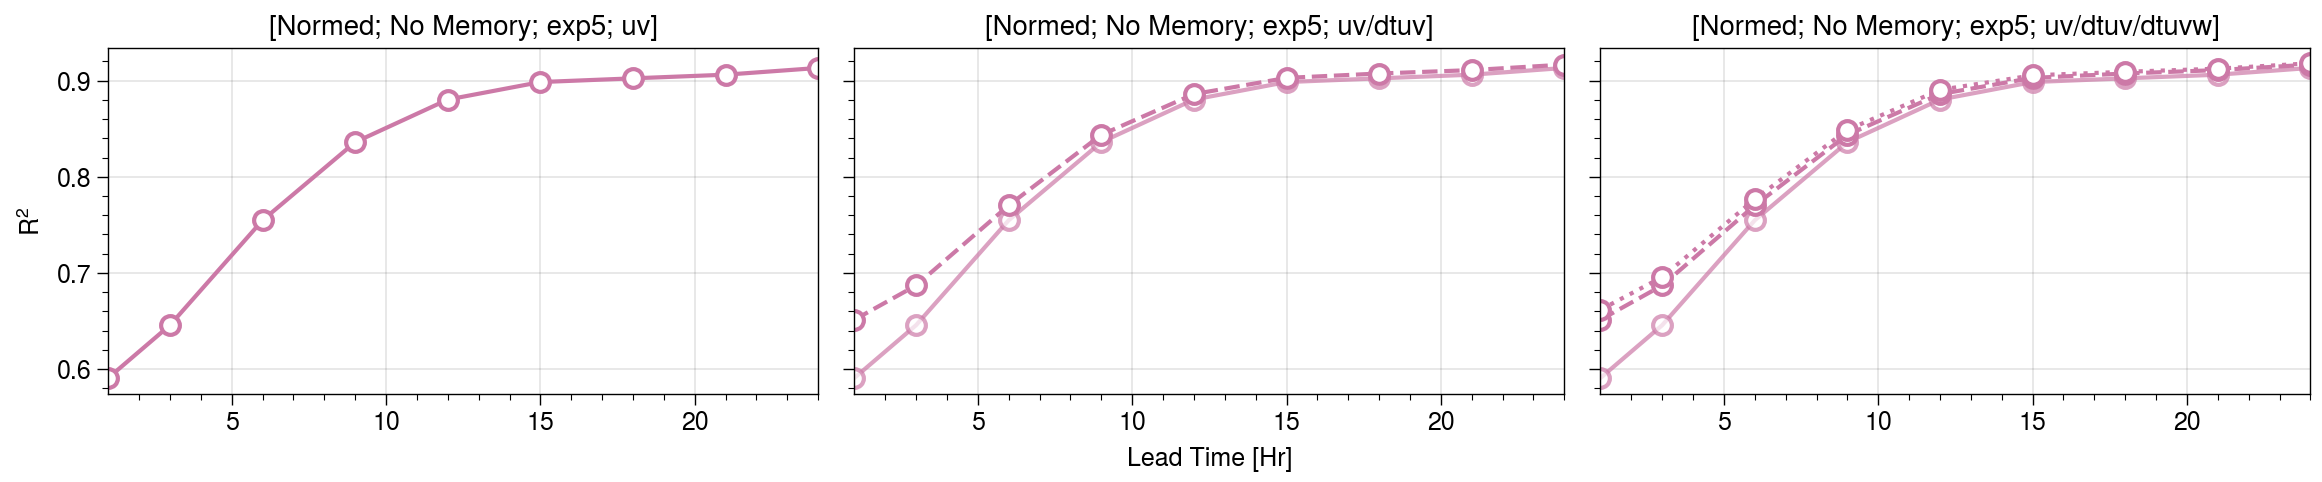

In [34]:
### LDTME = [1,3,6,9,12,15,18,21,24]
from matplotlib.lines import Line2D
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=3.55,refaspect=2.051)
# Figure 1
color = ['C1','C2','C3','C4','C5','C6']
exp = ['exp1','exp5','exp6']
label = ['uv','dtuv','dtuvw']
try:
    axs[0].plot(LDTME,norm_dict['exp6'][0],lw=1.5,alpha=1,c='C3',marker='o',mfc='w',mec='C3',mew=1,markersize=5)#,label=label[i]
except:
    axs[0].plot(LDTME,[np.asarray(norm_dict['exp6'][0])[obj-1] for obj in LDTME],lw=1.5,alpha=1,c='C3',marker='o',mfc='w',mec='C3',mew=1.5,markersize=6.75)
#axs[0].axhline(0.5,lw=2,color='k',ls='--')
axs[0].format(ylabel='R$^2$',xlabel='Lead Time [Hr]',title='[Normed; No Memory; exp5; uv]')

# Figure 2
axs[1].plot(LDTME,[np.asarray(norm_dict['exp6'][0])[obj-1] for obj in LDTME],lw=1.5,alpha=0.7,c='C3',marker='o',mfc='w',mec='C3',mew=1.5,markersize=6.75)
axs[1].plot(LDTME,np.asarray(norm_dict['exp6'][1]),lw=1.5,alpha=1,c='C3',marker='o',mfc='w',mec='C3',mew=1.5,markersize=6.75,ls='--')
#axs[1].axhline(0.5,lw=2,color='k',ls='--')
axs[1].format(ylabel='R$^2$',xlabel='Lead Time [Hr]',title='[Normed; No Memory; exp5; uv/dtuv]')
#axs[1].axhline(0.5,lw=2,color='k',ls='--')
axs[2].plot(LDTME,[np.asarray(norm_dict['exp6'][0])[obj-1] for obj in LDTME],lw=1.5,alpha=0.7,c='C3',marker='o',mfc='w',mec='C3',mew=1.5,markersize=6.75)
axs[2].plot(LDTME,np.asarray(norm_dict['exp6'][1]),lw=1.5,alpha=1,c='C3',marker='o',mfc='w',mec='C3',mew=1.5,markersize=6.75,ls='--')
axs[2].plot(LDTME,[np.asarray(norm_dict['exp6'][2])[obj-1] for obj in LDTME],lw=1.5,alpha=1,c='C3',marker='o',mfc='w',mec='C3',mew=1.5,markersize=6.75,ls='dotted')
#axs[2].axhline(0.5,lw=2,color='k',ls='--')
axs[2].format(ylabel='R$^2$',xlabel='Lead Time [Hr]',title='[Normed; No Memory; exp5; uv/dtuv/dtuvw]')
plt.savefig('./proc_fig/1212/test/reconperformance_exp_jamesfig1.png',dpi=400)
plt.show()

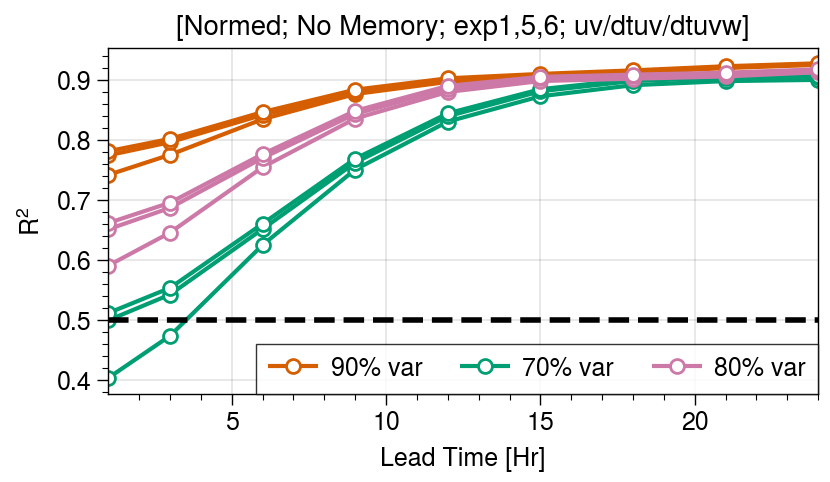

In [35]:
LDTME = [1,3,6,9,12,15,18,21,24]
from matplotlib.lines import Line2D
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=3.55,refaspect=2.051)
# Figure 1
color = ['C1','C2','C3','C4','C5','C6']
exp = ['exp1','exp5','exp6']
label = ['uv','dtuv','dtuvw']
for i in range(3):
    for j in range(3):
        try:
            axs[0].plot(LDTME,norm_dict[exp[i]][j],lw=1.5,alpha=1,c=color[i],marker='o',mfc='w',mec=color[i],mew=1,markersize=5)#,label=label[i]
        except:
            axs[0].plot(LDTME,[np.asarray(norm_dict[exp[i]][j])[obj-1] for obj in LDTME],
                        lw=1.5,alpha=1,c=color[i],marker='o',mfc='w',mec=color[i],mew=1,markersize=5)
axs[0].axhline(0.5,lw=2,color='k',ls='--')
axs[0].format(ylabel='R$^2$',xlabel='Lead Time [Hr]',title='[Normed; No Memory; exp1,5,6; uv/dtuv/dtuvw]')

legend_elements = [Line2D([0], [0], lw=1.5,alpha=1,c=color[0],marker='o',mfc='w',mec=color[0],mew=1,markersize=5, label='90% var'),
                   Line2D([0], [0], lw=1.5,alpha=1,c=color[1],marker='o',mfc='w',mec=color[1],mew=1,markersize=5, label='70% var'),
                   Line2D([0], [0], lw=1.5,alpha=1,c=color[2],marker='o',mfc='w',mec=color[2],mew=1,markersize=5, label='80% var'),]
axs[0].legend(handles=legend_elements, loc=4)
# Figure 2
#for i in range(3):
#    for j in range(3):
#        try:
#            axs[1].plot(LDTME,buoy_dict[exp[i]][j],lw=1.5,alpha=1,c=color[i],marker='o',mfc='w',mec=color[i],mew=1,markersize=5,linestyle='--')#,label=label[i]
#        except:
#            axs[1].plot(LDTME,[np.asarray(buoy_dict[exp[i]][j])[obj-1] for obj in LDTME],
#                        lw=1.5,alpha=1,c=color[i],marker='o',mfc='w',mec=color[i],mew=1,markersize=5,linestyle='--')
#axs[1].axhline(0.5,lw=2,color='k',ls='--')
#axs[1].format(ylabel='R$^2$',xlabel='Lead Time [Hr]',title='[Buoyancy normed; No Memory; exp1,5,6; uv/dtuv/dtuvw]')
plt.savefig('./proc_fig/1212/test/reconperformance_exp_jamesfig2.png',dpi=400)
plt.show()

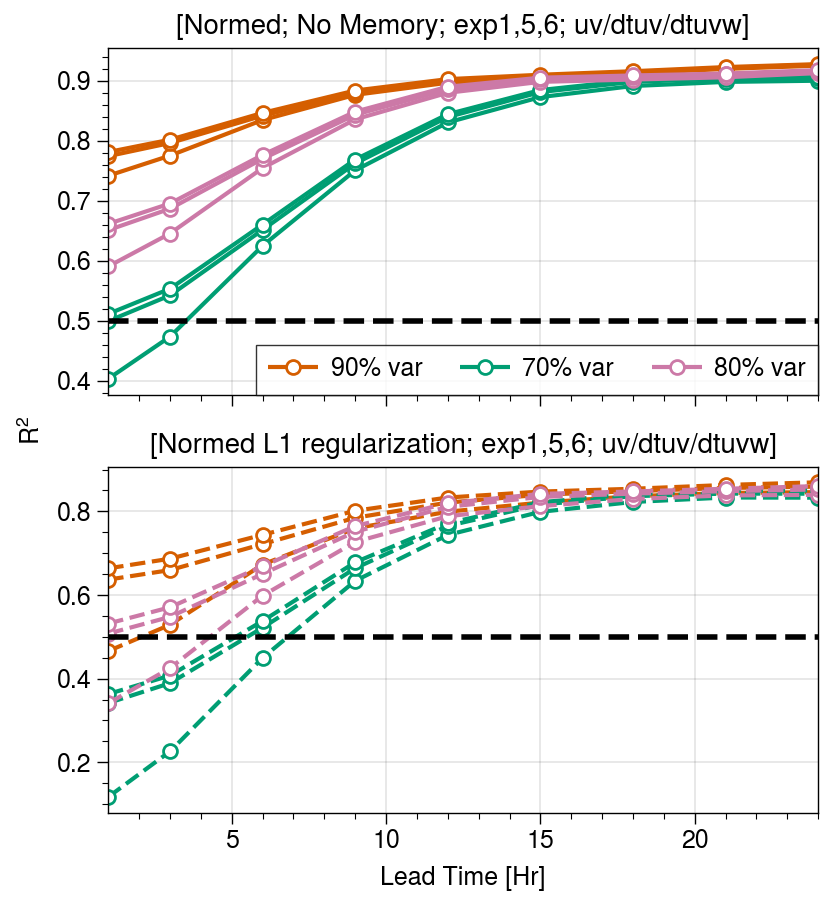

In [23]:
LDTME = [1,3,6,9,12,15,18,21,24]
from matplotlib.lines import Line2D
fig,axs = plot.subplots(ncols=1,nrows=2,axwidth=3.55,refaspect=2.051)
# Figure 1
color = ['C1','C2','C3','C4','C5','C6']
exp = ['exp1','exp5','exp6']
label = ['uv','dtuv','dtuvw']
for i in range(3):
    for j in range(3):
        try:
            axs[0].plot(LDTME,norm_dict[exp[i]][j],lw=1.5,alpha=1,c=color[i],marker='o',mfc='w',mec=color[i],mew=1,markersize=5)#,label=label[i]
        except:
            axs[0].plot(LDTME,[np.asarray(norm_dict[exp[i]][j])[obj-1] for obj in LDTME],
                        lw=1.5,alpha=1,c=color[i],marker='o',mfc='w',mec=color[i],mew=1,markersize=5)
axs[0].axhline(0.5,lw=2,color='k',ls='--')
axs[0].format(ylabel='R$^2$',xlabel='Lead Time [Hr]',title='[Normed; No Memory; exp1,5,6; uv/dtuv/dtuvw]')

legend_elements = [Line2D([0], [0], lw=1.5,alpha=1,c=color[0],marker='o',mfc='w',mec=color[0],mew=1,markersize=5, label='90% var'),
                   Line2D([0], [0], lw=1.5,alpha=1,c=color[1],marker='o',mfc='w',mec=color[1],mew=1,markersize=5, label='70% var'),
                   Line2D([0], [0], lw=1.5,alpha=1,c=color[2],marker='o',mfc='w',mec=color[2],mew=1,markersize=5, label='80% var'),]
axs[0].legend(handles=legend_elements, loc=4)
# Figure 2
for i in range(3):
    for j in range(3):
        try:
            axs[1].plot(LDTME,lasso_dict[exp[i]][j],lw=1.5,alpha=1,c=color[i],marker='o',mfc='w',mec=color[i],mew=1,markersize=5,linestyle='--')#,label=label[i]
        except:
            axs[1].plot(LDTME,[np.asarray(lasso_dict[exp[i]][j])[obj-1] for obj in LDTME],
                        lw=1.5,alpha=1,c=color[i],marker='o',mfc='w',mec=color[i],mew=1,markersize=5,linestyle='--')
axs[1].axhline(0.5,lw=2,color='k',ls='--')
axs[1].format(ylabel='R$^2$',xlabel='Lead Time [Hr]',title='[Normed L1 regularization; exp1,5,6; uv/dtuv/dtuvw]')
plt.savefig('./proc_fig/1212/reconperformance_exp_fig2.png',dpi=400)
plt.show()

In [11]:
UV_se,UV_va = read_in_processed(sorted(glob.glob('./output/1010_nc/R2/uv_s*')),sorted(glob.glob('./output/1010_nc/R2/uv_v*')))
DTUVW_se,DTUVW_va = read_in_processed(sorted(glob.glob('./output/1010_nc/R2/dtuvw_s*')),sorted(glob.glob('./output/1010_nc/R2/dtuvw_v*')))

exp = ['exp1','exp2','exp3','exp4','exp5','exp6']
UV_r2,DTUVW_r2 = [],[]
for index,obj in enumerate(exp):
    UV_r2.append(1-(np.asarray(UV_se[obj]['dudt'])+np.asarray(UV_se[obj]['dvdt'])+\
                    np.asarray(UV_se[obj]['dwdt']))/(np.asarray(UV_va[obj]['dudt'])+np.asarray(UV_va[obj]['dvdt'])+\
                                                        np.asarray(UV_va[obj]['dwdt'])))
    DTUVW_r2.append(1-(np.asarray(DTUVW_se[obj]['dudt'])+np.asarray(DTUVW_se[obj]['dvdt'])+\
                    np.asarray(DTUVW_se[obj]['dwdt']))/(np.asarray(DTUVW_va[obj]['dudt'])+np.asarray(DTUVW_va[obj]['dvdt'])+\
                                                        np.asarray(DTUVW_va[obj]['dwdt'])))

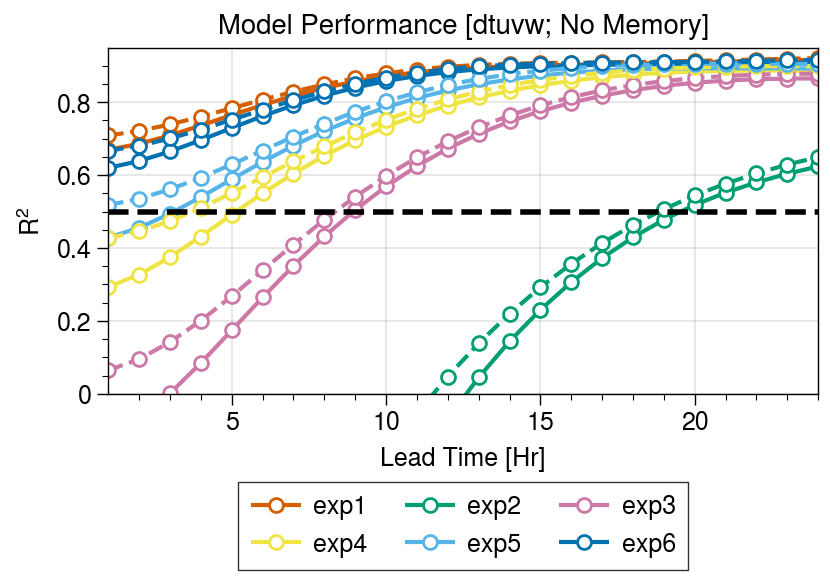

In [13]:
LDTME = np.linspace(0,23,24)+1

fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=3.55,refaspect=2.051)
color = ['C1','C2','C3','C4','C5','C6']
label = ['exp1','exp2','exp3','exp4','exp5','exp6']
for i in range(len(UV_r2)):
    axs[0].plot(LDTME,UV_r2[i],lw=1.5,alpha=1,c=color[i],marker='o',mfc='w',mec=color[i],mew=1,markersize=5,label=label[i])
for i in range(len(DTUVW_r2)):
    axs[0].plot(LDTME,DTUVW_r2[i],lw=1.5,alpha=1,c=color[i],marker='o',mfc='w',mec=color[i],mew=1,markersize=5,ls='--')
axs[0].axhline(0.5,lw=2,color='k',ls='--')
axs[0].legend(loc='b')
#axs[0].plot(LDTME,DTUVW_r2[3],
#           lw=1.5,alpha=1,c='C2',marker='o',mfc='w',mec='C2',mew=1,markersize=5)
axs[0].format(ylabel='R$^2$',xlabel='Lead Time [Hr]',title='Model Performance [dtuvw; No Memory]',ylim=[0,0.95])
plt.savefig('./proc_fig/1129/dtuvw_reconperformance_6exp.png',dpi=400)
plt.show()

#### Save

In [ ]:
import json,pickle
def save_to_pickle(loc=None,var=None):
    with open(loc,"wb") as f:
        pickle.dump(var,f)
    return None

path = '/scratch/08350/tg876493/mlr_output/exp6/dtuvw/reconstruct/all/'#allresi/'
save_to_pickle(loc=path+'/u9_recon_dthdtN',var=u9_recon_dthdt)
save_to_pickle(loc=path+'/v9_recon_dthdtN',var=v9_recon_dthdt)
save_to_pickle(loc=path+'/w9_recon_dthdtN',var=w9_recon_dthdt)

### Reconstruct - Sensitivity experiments

In [13]:
testu = u9_recon_dthdt[1][48].reshape(39,360,167)
testv = v9_recon_dthdt[1][48].reshape(39,360,167)
testw = w9_recon_dthdt[1][48].reshape(39,360,167)

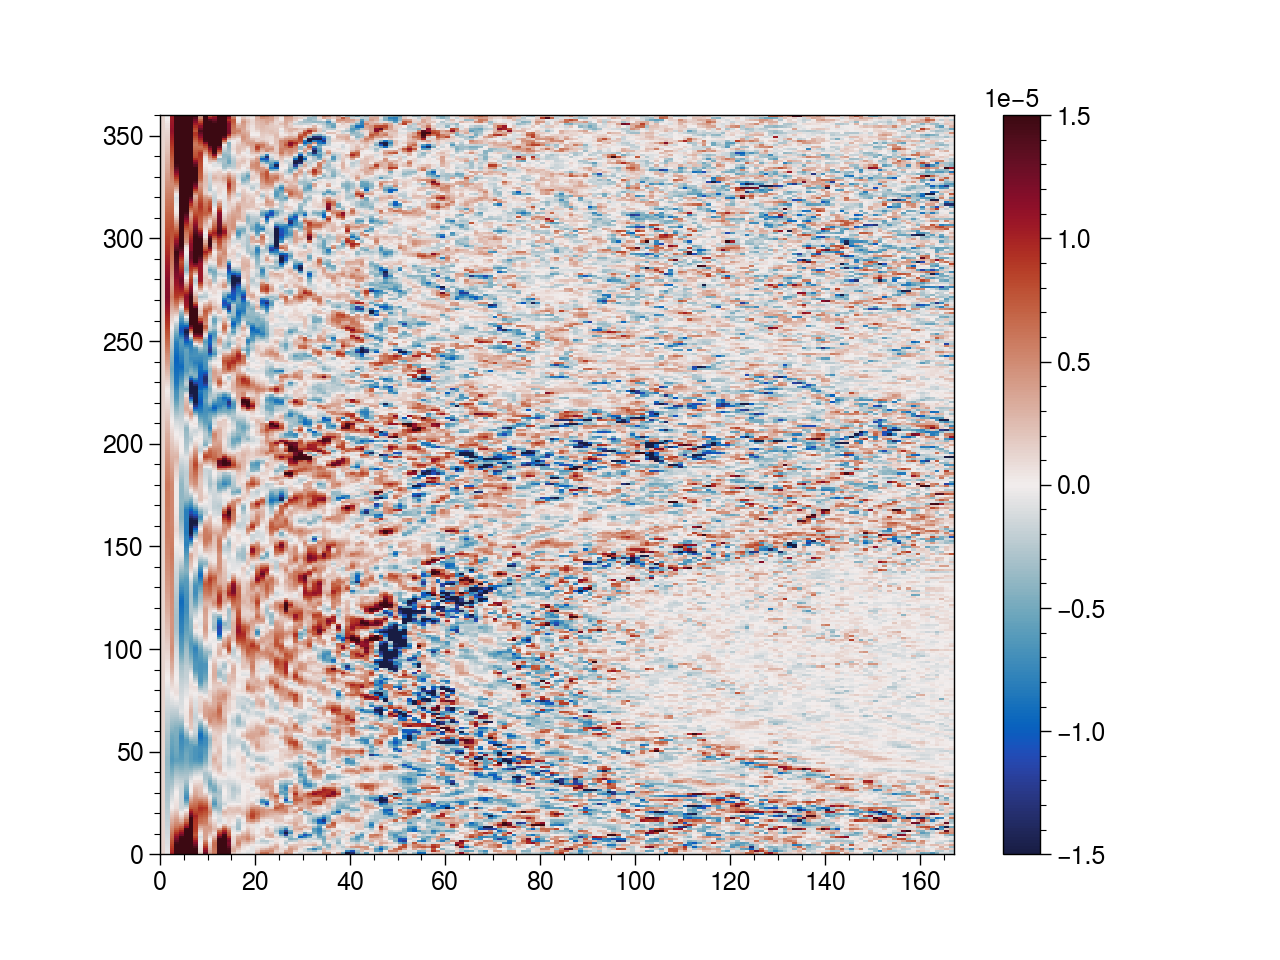

In [14]:
plt.pcolormesh(testw[6,:,:],vmin=-1.5e-5,vmax=1.5e-5,cmap='balance')
plt.colorbar()
plt.show()

In [15]:
path_coor = '/scratch/06040/tg853394/tc/output/redux/maria/ctl/post/U.nc'
coor = xr.open_dataset(path_coor)

import json,pickle
def read_some_azimuth_fields(fileloc=None,fieldname=None):
    dict_name = {}
    for inx,obj in enumerate(fileloc):
        field_read = xr.open_dataset(obj)
        dict_name[fieldname[inx]] = field_read
    return dict_name

ctrlvar_dict = read_some_azimuth_fields(fileloc=[origin_path+'ctl/azim_U10_0-144hr.nc'],fieldname=['U10'])

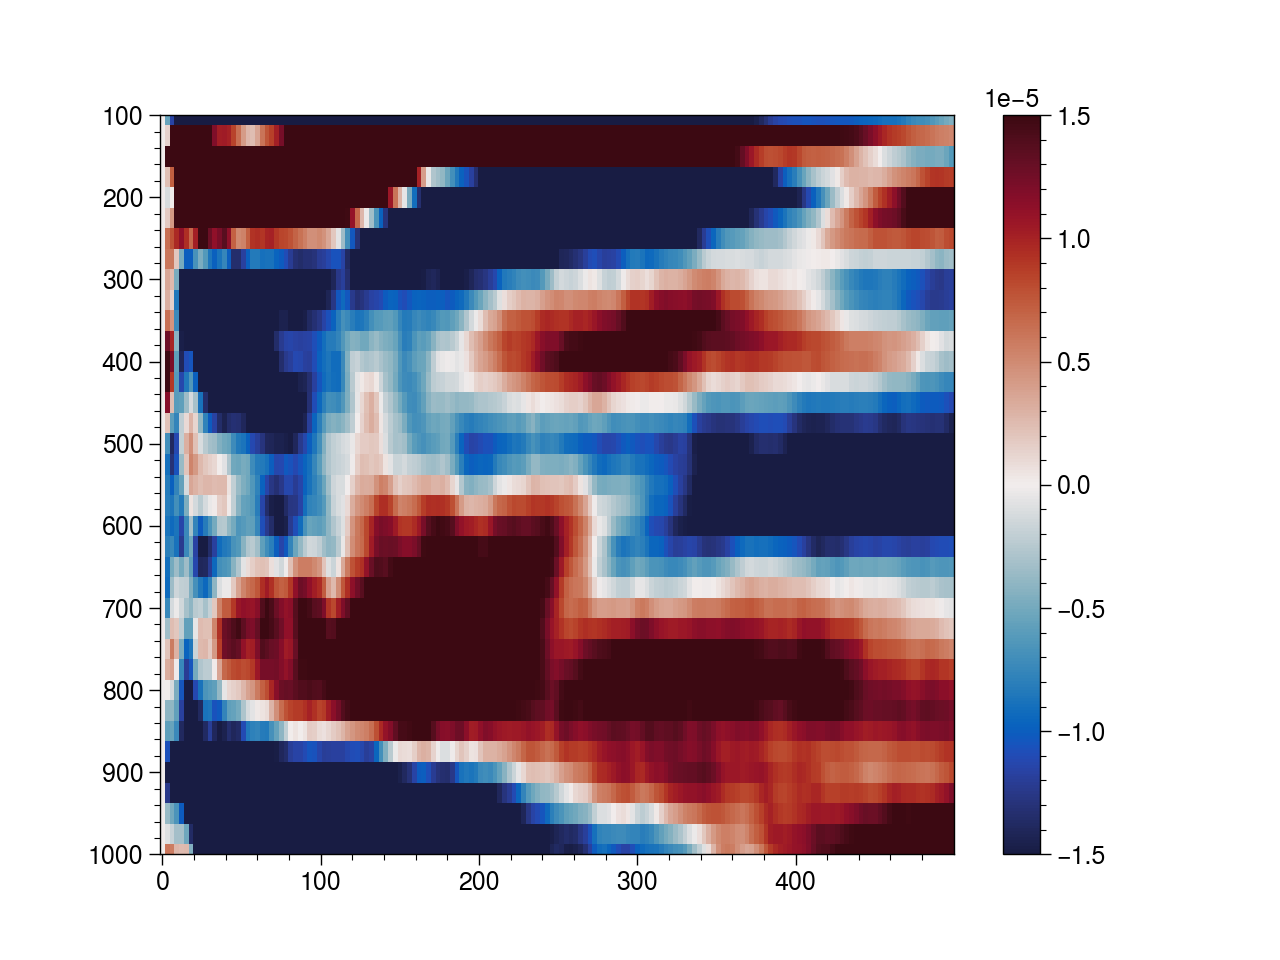

In [16]:
plt.pcolormesh(ctrlvar_dict['U10'].radius[:r500],coor.pres,np.nanmean(testu[:],axis=1),vmin=-1.5e-5,vmax=1.5e-5,cmap='balance',shading='auto')
plt.colorbar()
plt.ylim(1000,100)
plt.show()